In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
#PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
#PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = '/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

PYTHON_AUX_PATHS = '/scratch/wmql/tract_querier/tract_querier/:/scratch/wmql/tract_querier/tract_querier/nipype/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

In [3]:
from tractography import Tractography, tractography_to_file, tractography_from_files
import numpy as np

In [43]:
# gs: gold standard
# in: input
gs_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/Baseline_query_cst.left.vtp'
gs_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/Baseline_query_cst.right.vtp'

sr_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/WTV_query_cst.left.vtp'
sr_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/WTV_query_cst.right.vtp'

# implementation two / histogram

In [44]:
def ComputeBhattacharyyaCoeficient(gs_bundle,sr_bundle):
    from tractography import Tractography, tractography_to_file, tractography_from_files
    import numpy as np
    ## read in each fiber bundle
    gs_tractography = tractography_from_files(gs_bundle)
    gs_tracts = gs_tractography.tracts()
    gs_pts = np.vstack(gs_tracts)
    #
    sr_tractography = tractography_from_files(sr_bundle)
    sr_tracts = sr_tractography.tracts()
    sr_pts = np.vstack(sr_tracts)
    #
    mn = np.minimum(gs_pts.min(0), sr_pts.min(0))
    mx = np.maximum(gs_pts.max(0), sr_pts.max(0))
    bins = np.ceil((mx - mn))
    #
    gs_hist = np.array([ np.histogram(gs_pts[:,i], bins=bins[i], density=True, range=(mn[i], mx[i]))[0] for i in xrange(3) ])
    sr_hist = np.array([ np.histogram(sr_pts[:,i], bins=bins[i], density=True, range=(mn[i], mx[i]))[0] for i in xrange(3) ])
    #
    coefs = np.array([ np.sqrt( (gs_hist[i]*sr_hist[i])/(gs_hist[i].sum()*sr_hist[i].sum()) ).sum() for i in xrange(3) ])
    print(coefs)
    return coefs.mean()

In [45]:
bc = ComputeBhattacharyyaCoeficient(gs_cst_left_fn,sr_cst_left_fn)
print(bc)

[ 0.99936495  0.99884146  0.99933283]
0.999179746642


# partly results

In [46]:
def ComputeBhattacharyyaCoeficient(gs_bundle,sr_bundle):
    from tractography import Tractography, tractography_to_file, tractography_from_files
    import numpy as np
    def returnBundlePoints(bundle):
        tractography = tractography_from_files(bundle)
        tracts = tractography.tracts()
        ## sort all tracts from down to up in z direction
        for i in xrange(len(tracts)):
            last_idx = len(tracts[i])-1
            if tracts[i][:,2][0] > tracts[i][:,2][last_idx]:
                tracts[i] = tracts[i][::-1]
        #
        tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
        #
        pts = np.vstack(tracts)
        pts_last_quarter = np.vstack(tracts_last_quarter)
        return pts, pts_last_quarter
    ###
    def returnBhattCoef(gs_pts,sr_pts):
        mn = np.minimum(gs_pts.min(0), sr_pts.min(0))
        mx = np.maximum(gs_pts.max(0), sr_pts.max(0))
        bins = np.ceil((mx - mn))
        gs_hist = np.array([ np.histogram(gs_pts[:,i], bins=bins[i], density=True, range=(mn[i], mx[i]))[0] for i in xrange(3) ])
        sr_hist = np.array([ np.histogram(sr_pts[:,i], bins=bins[i], density=True, range=(mn[i], mx[i]))[0] for i in xrange(3) ])
        coefs = np.array([ np.sqrt( (gs_hist[i]*sr_hist[i])/(gs_hist[i].sum()*sr_hist[i].sum()) ).sum() for i in xrange(3) ])
        print(coefs)
        return coefs.mean()
    ###
    [gs_pts, gs_pts_last_quarter] = returnBundlePoints(gs_bundle)
    [sr_pts, sr_pts_last_quarter] = returnBundlePoints(sr_bundle)
    #
    coef = returnBhattCoef(gs_pts,sr_pts)
    print(coef)
    coef_last_quarter = returnBhattCoef(gs_pts_last_quarter,sr_pts_last_quarter)
    print(coef_last_quarter)

In [47]:
ComputeBhattacharyyaCoeficient(gs_cst_left_fn,sr_cst_left_fn)

[ 0.99936495  0.99884146  0.99933283]
0.999179746642
[ 0.99843096  0.9954401   0.99392698]
0.995932678015


In [35]:
def returnBundlePoints(bundle):
    tractography = tractography_from_files(bundle)
    tracts = tractography.tracts()
    ## sort all tracts from down to up in z direction
    for i in xrange(len(tracts)):
        last_idx = len(tracts[i])-1
        if tracts[i][:,2][0] > tracts[i][:,2][last_idx]:
            tracts[i] = tracts[i][::-1]
    #
    tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
    #
    pts = np.vstack(tracts)
    pts_last_quarter = np.vstack(tracts_last_quarter)
    return pts, pts_last_quarter

[gs_pts, pts_last_quarter] = returnBundlePoints(gs_cst_left_fn)

In [36]:
import pandas as pd
from ggplot import *

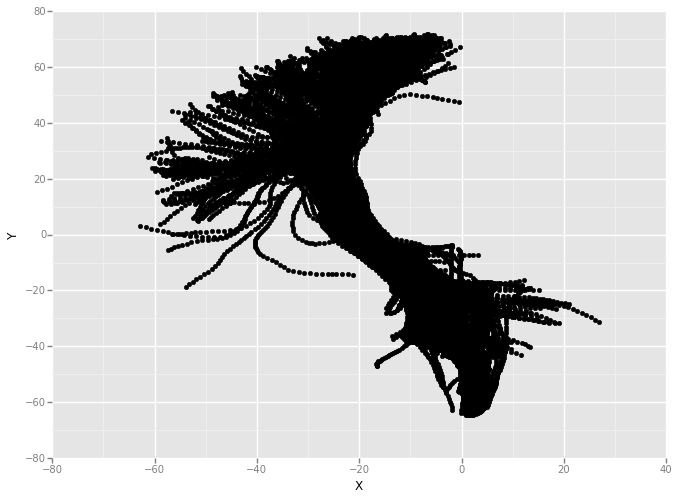

<ggplot: (330627829)>

In [37]:
DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

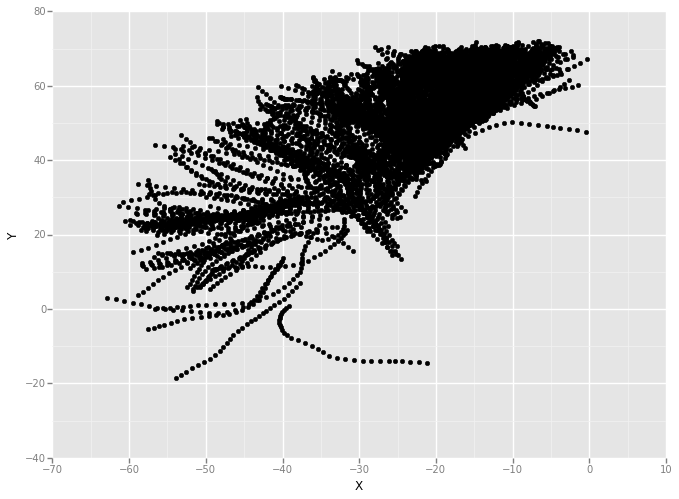

<ggplot: (321120077)>

In [38]:
DF_gs_x = pd.DataFrame(np.transpose([pts_last_quarter[:,0], pts_last_quarter[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

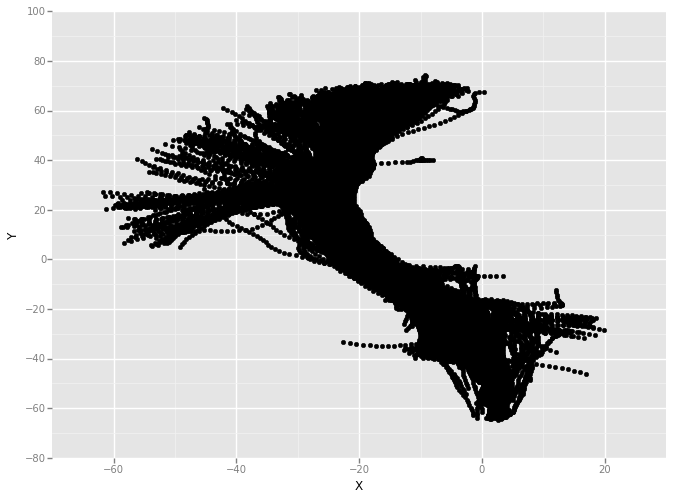

<ggplot: (320215113)>

In [48]:
def returnBundlePoints(bundle):
    tractography = tractography_from_files(bundle)
    tracts = tractography.tracts()
    ## sort all tracts from down to up in z direction
    for i in xrange(len(tracts)):
        last_idx = len(tracts[i])-1
        if tracts[i][:,2][0] > tracts[i][:,2][last_idx]:
            tracts[i] = tracts[i][::-1]
    #
    tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
    #
    pts = np.vstack(tracts)
    pts_last_quarter = np.vstack(tracts_last_quarter)
    return pts, pts_last_quarter

[gs_pts, pts_last_quarter] = returnBundlePoints(sr_cst_left_fn)

DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

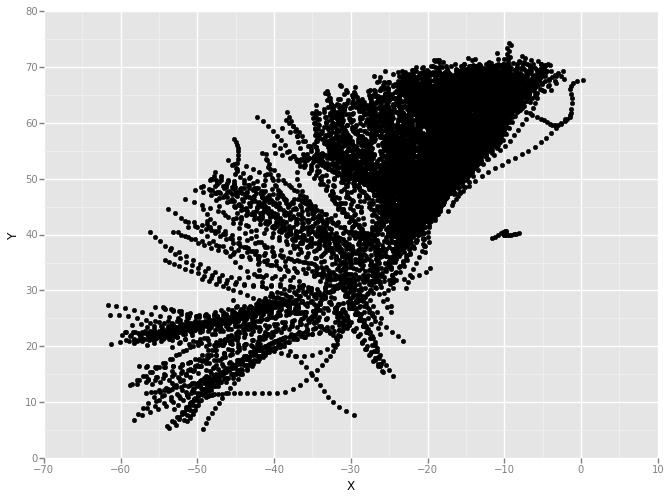

<ggplot: (330480905)>

In [49]:
DF_gs_x = pd.DataFrame(np.transpose([pts_last_quarter[:,0], pts_last_quarter[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

In [ ]:
gs_tractography = tractography_from_files(gs_cst_left_fn)
gs_tracts = gs_tractography.tracts()

In [ ]:
print(gs_tracts[10][:,2])
print(gs_tracts[10][:,2][0])
print(gs_tracts[10][:,2][len(gs_tracts[10])-1])

In [ ]:
for i in xrange(len(gs_tracts)):
    last_idx = len(gs_tracts[i])-1
    if gs_tracts[i][:,2][0] > gs_tracts[i][:,2][last_idx]:
        gs_tracts[i] = gs_tracts[i][::-1]

In [ ]:
print(gs_tracts[10][:,2])
print(gs_tracts[10][:,2][0])
print(gs_tracts[10][:,2][len(gs_tracts[10])-1])

In [ ]:
gs_pts = np.vstack(gs_tracts)

In [ ]:
import pandas as pd
from ggplot import *

In [ ]:
DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x
# DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,1], gs_pts[:,2]]))
# DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
# DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
# DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn
# DF_gs_x.rename(columns={"2": "Z"}, inplace=True)
# DF_gs_x

In [ ]:
ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

In [ ]:
gs_tracts_second_half = [gs_tracts[i][(len(gs_tracts[i])/2):] for i in xrange(len(gs_tracts))]

In [ ]:
gs_pts = np.vstack(gs_tracts_second_half)

In [ ]:
DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

In [ ]:
ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

In [ ]:
gs_pts = np.vstack(gs_tracts[10])

In [ ]:
DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn
DF_gs_x

In [ ]:
ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

In [ ]:
gs_pts = np.vstack(gs_tracts_second_half[10])

In [ ]:
DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 

In [ ]:
ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point() \
    + xlim(-30, 10) \
    + ylim(-80, 80)

In [ ]:
gs_pts = np.vstack(gs_tracts[0])

DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
print(DF_gs_x)

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

In [ ]:
gs_pts = np.vstack(gs_tracts_second_half[0])

DF_gs_x = pd.DataFrame(np.transpose([gs_pts[:,0], gs_pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point() \
    + xlim(-30, 5) \
    + ylim(-60, 60)